# Loan Default Prediction Model - Artificial Neural Network (ANN)
This notebook aims to predict loan default outcomes based on historical loan data. The approach includes data preprocessing, model training, and evaluation using a neural network in TensorFlow. 

## Contents

Step 1. Data Loading and Initial Setup

Step 2. Data Preprocessing

Step 3. Feature Engineering

Step 4. Neural Network Model

Step 5: Feature Importance Analysis

Step 6: Model Evaluation

Step 7: Hyperparameter Tuning

Step 8: Tradeoff Analysis

## Step 1. Data Loading and Initial Setup

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset and set display options
loan = pd.read_csv('../.Database/merged_cleaned_loan.csv')
loan.set_index('id',inplace=True)
pd.set_option('display.max_columns', None)


## Step 2. Data Preprocessing

To prepare our dataset, we will:
1. Drop non-numerical and irrelevant columns.
2. Separate the target variable (loan status) from the features.
3. Identify numerical and categorical features for encoding and scaling.


In [2]:
# As there is only 1 observation with home_ownership = ANY,
# we will drop that observation
loan = loan.drop(loan[loan['home_ownership'] == 'ANY'].index)

# Drop non-numerical and target columns from features
X = loan.drop(columns=['addr_state', 'emp_title', 'loan_status', 'issue_d', 'issue_y', 'issue_m', 'title'])

# Replace 'annual_inc' with its logarithmic version 'log_annual_inc' for normalization purposes
X = X.drop(columns=['annual_inc'])

# Remove outcome-related columns that would otherwise leak information
X = X.drop(columns=['loan_status_grouped'])

# Select the target variable for prediction
y = loan['loan_status_grouped']


## Step 3. Feature Engineering

We'll now split the columns into numerical and categorical types. Categorical variables will be one-hot encoded, and numerical variables will be scaled to improve model performance.

In [3]:
# Define categorical and numerical feature lists
categorical_columns = ['home_ownership', 'term','purpose','emp_length']
numerical_columns = X.select_dtypes(include=['float64']).columns

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Ensure alignment of train and test sets to handle any potential dummy variable mismatch
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Scale numerical columns to standardize the data distribution
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

## Step 4. Neural Network Model

We'll now define a neural network using TensorFlow's Keras API. This network has multiple dense layers with ReLU activation, optimized for classification.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

# Define the neural network architecture
model = keras.Sequential([
    layers.Dense(25, activation='relu', kernel_initializer='he_normal'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid') # 1 output class for binary classification
])

### Compile and Train the Model
The model is compiled with `mean_squared_error` as the loss function and `adam` as the optimizer. The model is trained for 10 epochs with a batch size of 64.

In [10]:
# Compile the model with Adam optimizer and appropriate loss for multi-class classification
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

# Train the model with training data and validate on a portion of the training set
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.7824 - loss: 0.1618 - val_accuracy: 0.7822 - val_loss: 0.1574
Epoch 2/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7878 - loss: 0.1560 - val_accuracy: 0.7838 - val_loss: 0.1604
Epoch 3/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.7877 - loss: 0.1558 - val_accuracy: 0.7873 - val_loss: 0.1576
Epoch 4/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.7855 - loss: 0.1568 - val_accuracy: 0.7861 - val_loss: 0.1562
Epoch 5/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.7841 - loss: 0.1573 - val_accuracy: 0.7874 - val_loss: 0.1577
Epoch 6/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.7872 - loss: 0.1556 - val_accuracy: 0.7870 - val_loss: 0.1561
Epoch 7/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.7887 - loss: 0.1545 - val_accuracy: 0.7875 - val_loss: 0.1564
Epoch 8/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.7879 - loss: 0

## Step 5. Feature Importance Analysis

We can use the `get_weights()` method to extract the weights of the neurons in the network. This method returns a list of arrays, where each array corresponds to the weights of a single neuron. We can then use these weights to calculate the feature importance.

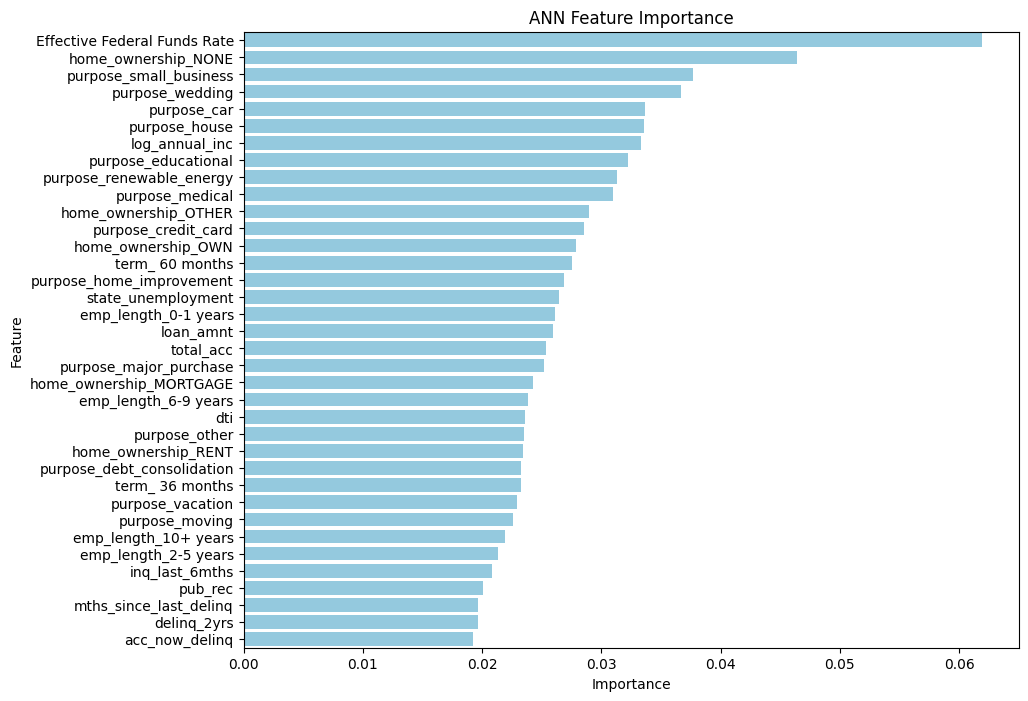

In [11]:
# Extract weights from the first layer
weights = model.layers[0].get_weights()[0]

# Calculate feature importance based on the absolute values of the weights
feature_importance = np.abs(weights).sum(axis=1)

# Scale the importance values by dividing by the total sum to get percentages
total_importance = feature_importance.sum()
percentage_importance = feature_importance / total_importance

# Create a DataFrame for better visualization
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': percentage_importance
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, color='skyblue')
plt.title('ANN Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Step 6. Model Evaluation

After training, the model is evaluated on the test set. We'll predict classes, generate a classification report, and plot a confusion matrix for performance visualization.


1612/1612 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


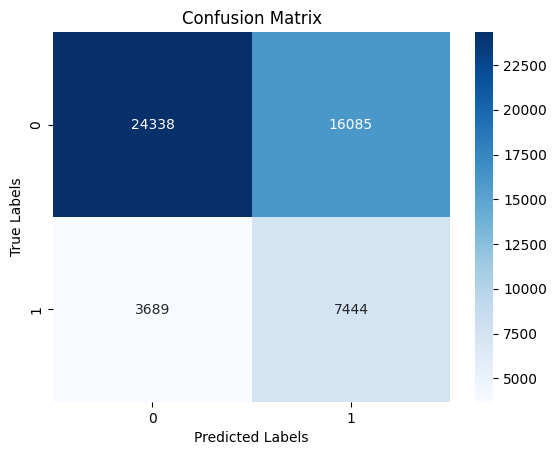

In [12]:
# Predict class probabilities and convert them to class labels
y_pred_prob = model.predict(X_test)

from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score

threshold = 0.2
y_pred = (y_pred_prob >= threshold).astype(int) 

# Generating evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting heatmap for confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=True,
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Step 7. Hyperparameter Tuning

We now tune the thresholds for the ANN model which will select the best model based on the validation accuracy.

In [8]:
# Define the range of thresholds between 0.2 and 0.3
thresholds = np.arange(0.2, 0.31, 0.01)  # Thresholds from 0.2 to 0.3 in steps of 0.01
confusion_matrices = []
f1_scores = []

for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append((threshold, cm))
    
    # Calculate F1 score for the current threshold
    f1 = f1_score(y_test, y_pred)
    f1_scores.append((threshold, f1))
    
# Identify the threshold with the highest F1 score
best_threshold, best_f1 = max(f1_scores, key=lambda x: x[1])

# Print the confusion matrices and F1 scores for each threshold
for threshold, cm in confusion_matrices:
    print(f"Threshold: {threshold:.2f}\nConfusion Matrix:\n{cm}\n")

print(f"Best Threshold: {best_threshold:.2f} with F1 Score: {best_f1:.2f}")

Threshold: 0.20
Confusion Matrix:
[[25488 14935]
 [ 3946  7187]]

Threshold: 0.21
Confusion Matrix:
[[26626 13797]
 [ 4272  6861]]

Threshold: 0.22
Confusion Matrix:
[[27679 12744]
 [ 4578  6555]]

Threshold: 0.23
Confusion Matrix:
[[28732 11691]
 [ 4892  6241]]

Threshold: 0.24
Confusion Matrix:
[[29737 10686]
 [ 5205  5928]]

Threshold: 0.25
Confusion Matrix:
[[30611  9812]
 [ 5496  5637]]

Threshold: 0.26
Confusion Matrix:
[[31461  8962]
 [ 5808  5325]]

Threshold: 0.27
Confusion Matrix:
[[32221  8202]
 [ 6133  5000]]

Threshold: 0.28
Confusion Matrix:
[[32956  7467]
 [ 6429  4704]]

Threshold: 0.29
Confusion Matrix:
[[33656  6767]
 [ 6741  4392]]

Threshold: 0.30
Confusion Matrix:
[[34296  6127]
 [ 7005  4128]]

Best Threshold: 0.20 with F1 Score: 0.43


## Step 8. Tradeoff Analysis - TN/FN Ratio and Approved Loans

We can use the following code to calculate the TN/FN ratio and the approved loans.

1612/1612 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Maximum TN/FN Ratio: 49.00 at Threshold: 0.02


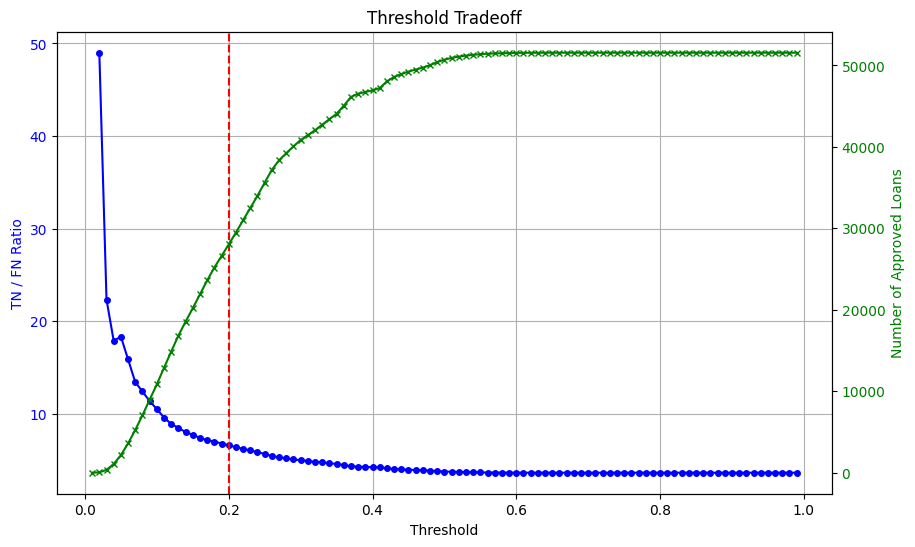

In [13]:
# Plotting True Negatives (TN) / False Negatives (FN) and number of approved loans against the threshold,

y_pred_prob = model.predict(X_test)

ratios = []
approved_loans = []
thresholds = np.arange(0.01, 1.00, 0.01)

for threshold in thresholds:
    y_pred = (y_pred_prob >= threshold).astype(int)
    TN = np.sum((y_pred.flatten() == 0) & (y_test.values == 0))
    FN = np.sum((y_pred.flatten() == 0) & (y_test.values == 1))
    
    if FN > 0:
        ratio = TN / FN
    else:
        ratio = np.nan 

    ratios.append(ratio)
    approved_loans.append(TN + FN)

# Filter out infinite and NaN ratios
valid_ratios = [(ratio, threshold) for ratio, threshold in zip(ratios, thresholds) if pd.notna(ratio) and ratio != np.inf]

# Find the maximum ratio and its corresponding threshold
if valid_ratios:
    max_ratio, best_threshold = max(valid_ratios, key=lambda x: x[0])

    # Print the threshold that gives the maximum ratio
    print(f'Maximum TN/FN Ratio: {max_ratio:.2f} at Threshold: {best_threshold:.2f}')
else:
    print("No valid ratios found.")

# Plotting the results
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the TN/FN ratio on the primary y-axis
ax1.plot(thresholds, ratios, marker='o', markersize=4, color='b', label='TN / FN Ratio')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('TN / FN Ratio', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid()

# Create a secondary y-axis to plot the number of approved loans
ax2 = ax1.twinx()
ax2.plot(thresholds, approved_loans, marker='x', markersize=4, color='g', label='Number of Approved Loans')
ax2.set_ylabel('Number of Approved Loans', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Set limits for the y-axes
try:
    max_ratio_limit = max(filter(lambda x: x != np.inf, ratios), default=0)
    ax1.set_ylim(0, max_ratio_limit * 1.1)

    max_approved_loans_limit = max(approved_loans, default=0)
    ax2.set_ylim(0, max_approved_loans_limit * 1.1)
except ValueError:
    pass

# Plotting a vertical line at threshold = 0.2
ax1.axvline(x=0.2, color='r', linestyle='--', label='Threshold = 0.2')

plt.title('Threshold Tradeoff')

plt.show()


In [14]:
# Export results
ann_results = pd.DataFrame({
    "Threshold": thresholds,
    "Ratio": ratios,
    "Approved Loan": approved_loans
})

# Export to CSV
ann_results.to_csv("../.systemfiles/ann_results.csv", index=False)